<hr style="height:10px"> 
 
<div class='container2'>
	<div style='padding: 0 7em 2em 0em;'>
	<h1>Trabalho de Inteligência Artificial</h1>
    <h3> <a href="https://github.com/amandakouchi">Amanda Kouchi</a> &#x25CF; <a href="https://github.com/biarog">Beatriz Rogers</a> &#x25CF; <a href="https://github.com/matteoavan">Matteo Savan</a> &#x25CF; <a href="https://github.com/RaulYKomai">Raul Y. Komai</a>
	</div>
</div>


 <hr style="height:5px"> 

    
<h2>Algoritmos e Avaliação em Agrupamento</h2>

## Introdução

Neste *notebook*, exploramos três métodos de agrupamento: K-Médias, Single-Link e Complete-Link; e o Índice Rand. Cada um desses algoritmos, todos implementados em Python, aplica uma abordagem diferente de organização de dados em grupos, o que influencia tanto na forma como os clusters são definidos quanto na interpretação que podemos ter dos resultados obtidos. 
	
O objetivo desse projeto, referente à matéria de Inteligência Artificial da professora Katti Faceli, é construir e aplicar os algoritmos aos datasets fornecidos, avaliando a qualidade das partições resultantes por meio do Índice Rand Ajustado, comparando-os com as partições reais.


---

## Recursos Necessários

Para este *notebook*, deve ser utilizado o `Python 3.6` ou superior com as seguintes bibliotecas externas, que deverão ser instaladas:

* [`matplotlib`](versão 3.9.2 ou superior): construção e exibição de gráficos variados
* [`numpy`](versão 2.1 ou superior): manipulação de dados em formato de vetores e matrizes
* [`pandas`](versão 2.2.2 ou superior): manipulação de dados em formato de tabelas
* [`sklearn`](versão x.x ou superior): completar
* [`seaborn`]versão x.x ou superior): completar

A biblioteca [`os`](https://docs.python.org/3/library/os.html), para realizar tarefas específicas ao Sistema Operacional, também será utilizada. Por fazer parte da [Biblioteca Padrão de Python](https://docs.python.org/pt-br/3/library/), sua instalação não é necessária.

Serão utilizados também os conjuntos de dados disponibilizados junto com este *notebook*, que se encontram no diretório `datasets`, em formato de arquivo `.txt`.

In [40]:
## Imports
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import cluster 
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
import seaborn as sns
import sys

%matplotlib inline

DATASETS_DIR = 'datasets'

In [41]:
## Função auxiliar para carregar dados
def load_dataset(dataset_name):
    dataset = pd.read_csv(os.path.join(DATASETS_DIR, dataset_name+'.txt'), sep='\t', index_col = 0)
    return dataset

In [42]:
## Função auxiliar para plottar os dados de entrada
def plot_entry_data(data) -> None:
    X = data[['d1', 'd2']]
    plt.scatter(X["d1"],X["d2"], c="red")
    plt.xlabel("d1")
    plt.ylabel("d2")
    plt.show()

In [43]:
## Funcao auxiliar para definir o dataframe apos a agregacao
def create_df(data, clusters):
    df = pd.DataFrame(data)
    df.columns = ["d1","d2"]
    df["cluster"] = clusters
    
    return df

In [44]:
## Função auxiliar para plottar após funcao de agregacao
def plot_grouped_data(df, n_clusters) -> None:
    cores = sns.color_palette()[0:n_clusters]
    df = df.sort_values("sample_label")
    sns.scatterplot(data = df, x=df["d1"], y=df["d2"], hue=df["cluster"], palette=cores)
    plt.show()

In [45]:
## Funcao auxiliar de exportar arquivo
def export_dataframe(df, n_group, n_arquivo) -> None :
    select = ['sample_label', 'cluster']
    select = [x for x in df.columns if x in select]
    export = df[select]
    export.to_csv(n_arquivo + '_' + n_group + '.csv')

---
## K-médias

O K-Médias busca minimizar a soma das distâncias quadradas entre os pontos de dados e o centróide do cluster ao qual pertencem. O algoritmo começa escolhendo k centróides iniciais, que podem ser selecionados aleatoriamente, e então itera entre atribuir cada ponto ao centróide mais próximo e recalcular os centróides dos clusters formados. O processo continua até que os centróides se estabilizem ou até que o número máximo de iterações seja atingido. 

O nosso algoritmo recebe como entrada um arquivo texto com o conjunto de dados, o número de clusters desejado e o número de iterações que o algoritmo deverá executar. A saída produzida é um arquivo com uma partição do conjunto de dados no mesmo formato que o da partição real.

In [46]:
## Entrada de dados
maxiter = 10
k = 10
nome_arquivo = 'monkey'

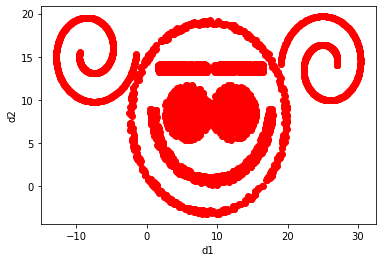

In [47]:
dados = load_dataset(nome_arquivo)
X = dados[['d1', 'd2']]
plot_entry_data(data=dados)

In [48]:
## Iniciar centróides
def initiate_centroids(k,dset):
    centroides = dset.sample(k)
    return centroides

np.random.seed(86)
centroids = initiate_centroids(k,X)

In [49]:
## Função de distância
def rsserr(a,b):
    return np.square(np.sum((a-b)**2)) 

In [50]:
## Atribuição de das amostras aos centróides
def centroid_assignation(dset, centroids):
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimar erro
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Pegar o centróide mais próximo e o erro
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Adicionar os valores às suas listas correspondentes
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

In [51]:
## Função do K-médias
def kmeans(dset, k, maxiter):
    working_dset = dset.copy()
    err = []
    
    centroids = initiate_centroids(k, dset)

    for i in range(maxiter):
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids

In [52]:
## Execução do K-médias
np.random.seed(86)
X['centroid'], X['error'], centroids =  kmeans(X[['d1','d2']], k, maxiter)

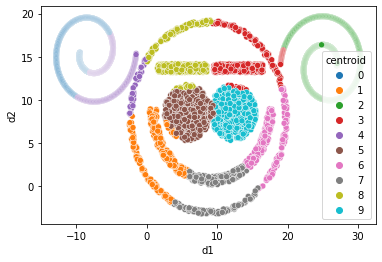

In [54]:
## Plotar após k-médias
df = pd.DataFrame(X)
df.columns = ['d1','d2', 'centroid', 'error']
cores = sns.color_palette()[0:k]
sns.scatterplot(data = df, x=df["d1"], y=df["d2"], hue=df["centroid"], palette=cores)
plt.show()

In [209]:
## Exportar arquivo
select_ = ['sample_label', 'centroid']
select = [x for x in df.columns if x in select_]
export = df[select]
export.to_csv(nome_arquivo + '.csv')

---
## Single-Link

O Single-Link é um algoritmo hierárquico que forma clusters. Inicialmente, cada  dado é tratado como um cluster individual. Após iterar, há união dos dois clusters mais próximos em cada etapa, onde a proximidade é determinada pela menor distância entre qualquer par de pontos nos dois clusters.

O nosso algoritmo recebe como entrada um arquivo texto com o conjunto de dados kMin e kMax (2 e 5, respectivamente). A saída produzida é um ou mais arquivos, cada um com uma partição do conjunto de dados.

In [400]:
## Entrada de dados
numero_clusters = 2
nome_arquivo = 'teste'

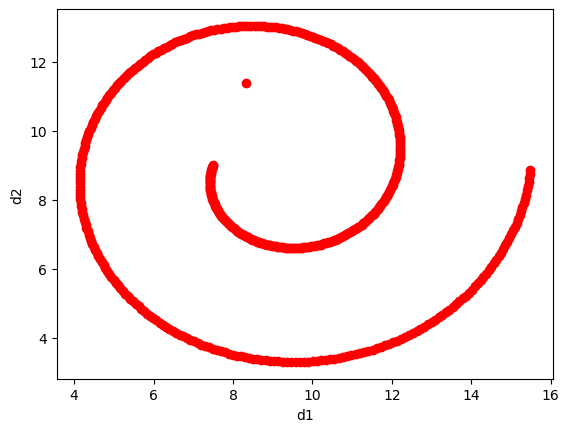

In [396]:
## Carregando dados e plottando grafico inicial
dados = load_dataset(nome_arquivo)
plot_entry_data(data=dados)

In [397]:
## Cálculo Matriz de Distância
matrix_despacial = distance_matrix(x=dados.values, y=dados.values)
matrix_base = np.full((len(matrix_despacial), len(matrix_despacial[0])), 1)

In [398]:
## Função de Single Link
def single_link(m_distancias:np, n_clusters:int):
    single = [-1]*len(dados)
    counter:int = 0
    cluster_id:int = -1
    for iter in range(len(m_distancias) - n_clusters):
        min:int = sys.maxsize
        line:int = 0
        column:int = 0
        
        cluster:bool = True
        
        for idx_x, x in enumerate(m_distancias):
            for idx_y, y in enumerate(x):
                if y < min and y > 0:
                    min = y
                    line = idx_x
                    column = idx_y

        if single[line] < 0 and single[column] < 0:
            cluster = False
        
        if cluster:
            
            if single[line] >= 0:
                cluster_id = -single[line] -1
            elif single[column] >= 0:
                cluster_id = -single[column] -1
            
            m_distancias[column][line] = m_distancias[line][column] = cluster_id
            
            idx_column = idx_line = -1
            for idx_n, n in enumerate(single):
                if n == single[column] and idx_n != column and n > -1:
                    idx_column = idx_n
                    single[idx_column] = -cluster_id - 1
                    m_distancias[idx_column][column] = m_distancias[column][idx_column] = cluster_id
                    m_distancias[idx_column][line] = m_distancias[line][idx_column] = cluster_id
                elif n == single[line] and idx_n != line and n > -1:
                    idx_line = idx_n
                    single[idx_line] = -cluster_id - 1
                    m_distancias[idx_line][column] = m_distancias[column][idx_line] = cluster_id
                    m_distancias[idx_line][line] = m_distancias[line][idx_line] = cluster_id
                if idx_column > -1 and idx_line > -1:
                    m_distancias[idx_line][idx_column] = m_distancias[idx_column][idx_line] = cluster_id
            
            single[line] = single[column] = -cluster_id - 1

        else :
            m_distancias[column][line] = m_distancias[line][column] = -counter - 1
            single[line] = single[column] = counter
            counter += 1

        for idx_x, x in enumerate(m_distancias[line]):
            if m_distancias[line][idx_x] <= m_distancias[column][idx_x] and m_distancias[column][idx_x] > 0:
                m_distancias[column][idx_x] = m_distancias[idx_x][column] = x
            elif m_distancias[line][idx_x] > m_distancias[column][idx_x] and m_distancias[line][idx_x] > 0:
                m_distancias[line][idx_x] = m_distancias[idx_x][line] = m_distancias[idx_x][column]

    for idx_n, n in enumerate(single):
        if n == -1:
            single[idx_n] = max(single) + 1
    
    return single

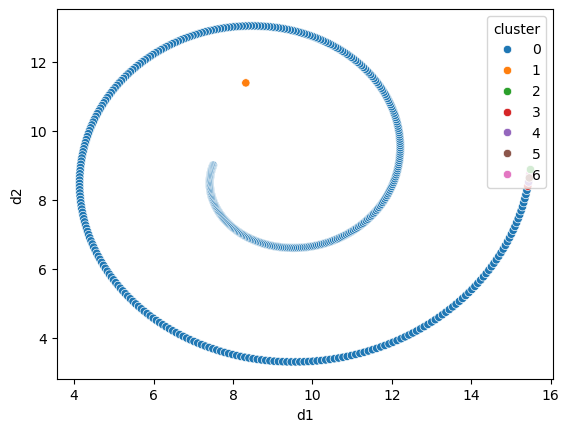

In [399]:
single = single_link(matrix_despacial, numero_clusters)
plot_grouped_data(dados=dados, n_clusters=numero_clusters, clusters=single)

In [ ]:
df = create_df(dados, numero_clusters)
plot_grouped_data(df, numero_clusters)
export_dataframe(df, 'single_link', nome_arquivo)

---
## Complete-Link

O Complete-Link, assim como o Single-Link, é um algoritmo hierárquico aglomerativo. Mas, em vez de considerar a menor distância entre os pontos dos clusters, o Complete-Link considera a maior distância entre os pontos de dois clusters.

O nosso algoritmo recebe como entrada um arquivo texto com o conjunto de dados kMin e kMax (2 e 5, respectivamente). A saída produzida é um ou mais arquivos, cada um com uma partição do conjunto de dados.

In [609]:
## Entrada de dados
numero_clusters = 1
nome_arquivo = 'testando'

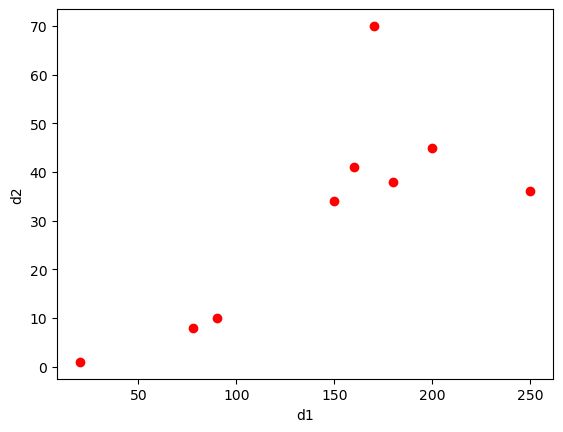

In [610]:
## Carregando dados e plottando grafico inicial
dados = load_dataset(nome_arquivo)
plot_entry_data(data=dados)

In [611]:
## Cálculo Matriz de Distância
matrix_despacial = distance_matrix(x=dados.values, y=dados.values)

In [612]:
## Função de Complete Link
def complete_link(m_distancias:np, n_clusters:int):
    complete = [-1]*len(m_distancias)
    total_clusters = len(m_distancias)
    counter:int = 0
    cluster_id:int = -1
    
    if total_clusters > n_clusters:      
        while(total_clusters >= n_clusters): 
            n_menos1 = 0
            line:int = 0
            column:int = 0
            
            cluster:bool = True
            
            shortest_dist = np.min(m_distancias[m_distancias>0])
            line = np.where(m_distancias == shortest_dist)[0][0]
            column = np.where(m_distancias == shortest_dist)[1][0]

            print("sd: ", shortest_dist)
            
            #print("c1(linha): ", cluster1, "c2(coluna): ", cluster2)
            print("---linha : ", line, "---coluna : ", column)

            if complete[line] < 0 and complete[column] < 0:
                cluster = False
            
            if cluster:
                
                if complete[line] >= 0:
                    cluster_id = -complete[line] -1
                elif complete[column] >= 0:
                    cluster_id = -complete[column] -1
                
                m_distancias[column][line] = m_distancias[line][column] = cluster_id
                
                
                print(m_distancias[7])
                print(m_distancias[8])
                
                idx_column = idx_line = -1
                for idx_n, n in enumerate(complete):
                    if n == complete[column] and idx_n != column and n > -1:
                        print("coluna: ", column)
                        idx_column = idx_n
                        complete[idx_column] = -cluster_id - 1
                        m_distancias[idx_column][column] = m_distancias[column][idx_column] = cluster_id
                        m_distancias[idx_column][line] = m_distancias[line][idx_column] = cluster_id
                    elif n == complete[line] and idx_n != line and n > -1:
                        print("line: ", line)
                        idx_line = idx_n
                        complete[idx_line] = -cluster_id - 1
                        m_distancias[idx_line][column] = m_distancias[column][idx_line] = cluster_id
                        m_distancias[idx_line][line] = m_distancias[line][idx_line] = cluster_id
                    if idx_column > -1 and idx_line > -1:
                        m_distancias[idx_line][idx_column] = m_distancias[idx_column][idx_line] = cluster_id
                        m_distancias[idx_column][idx_line] = m_distancias[idx_column][idx_line] = cluster_id
                
                complete[line] = complete[column] = -cluster_id - 1

            else :
                m_distancias[column][line] = m_distancias[line][column] = -counter - 1
                complete[line] = complete[column] = counter
                counter += 1

            for idx_x, x in enumerate(m_distancias[line]):
                if m_distancias[line][idx_x] >= m_distancias[column][idx_x] and m_distancias[column][idx_x] > 0:
                    m_distancias[column][idx_x] = m_distancias[idx_x][column] = x
                elif m_distancias[line][idx_x] < m_distancias[column][idx_x] and m_distancias[line][idx_x] > 0:
                    m_distancias[line][idx_x] = m_distancias[idx_x][line] = m_distancias[idx_x][column]
            
            for x in complete:
                if x == -1:
                    n_menos1 += 1
            
            total_clusters = len(set(complete)) - 1 + n_menos1
    
    for idx_n, n in enumerate(complete):
        if n == -1:
            complete[idx_n] = max(complete) + 1
    
    return complete

sd:  12.165525060596439
---linha :  2 ---coluna :  3
sd:  12.206555615733702
---linha :  1 ---coluna :  6
sd:  21.18962010041709
---linha :  7 ---coluna :  8
sd:  39.05124837953327
---linha :  5 ---coluna :  7
[ 70.0285656   51.19570294 127.48725426 127.48725426 185.29975715
  -3.          51.19570294   0.          -3.        ]
[ 70.0285656   51.19570294 127.48725426 127.48725426 185.29975715
  39.05124838  51.19570294  -3.           0.        ]
coluna:  7
sd:  51.19570294468082
---linha :  1 ---coluna :  5
[ 86.92525525  51.19570294 127.48725426 127.48725426 185.29975715
  -3.          51.19570294   0.          -3.        ]
[ 70.0285656   51.19570294 127.48725426 127.48725426 185.29975715
  -3.          51.19570294  -3.           0.        ]
1
coluna:  5
coluna:  5
sd:  70.02856560004639
---linha :  0 ---coluna :  8
[ 86.92525525  -2.         127.48725426 127.48725426 185.29975715
  -2.          -2.           0.          -3.        ]
[ -2.          -2.         127.48725426 127.4872542

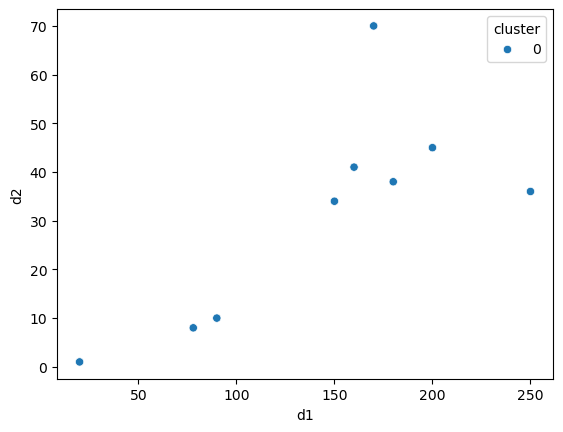

In [613]:
complete = complete_link(matrix_despacial, numero_clusters)
#print(len(complete))
#print(complete)
plot_grouped_data(dados=dados, n_clusters=numero_clusters, clusters=complete)

In [ ]:
df = create_df(dados, numero_clusters)
plot_grouped_data(df, numero_clusters)
export_dataframe(df, 'complete_link', nome_arquivo)

---
## S-rand

Uma etapa muito importante quando se trata de agrupamento é a validação externa. Ela busca validar as partições obtidas pelos algoritmos em comparação com a partição real dos dados que é esperada. Para isto, utiliza-se o Índice Rand (RI).

O Indice Rand é um dos indicativos mais tradicionais de qualidade de agrupamento de elementos. Ele faz uma comparação par-a-par entre os objetos obtidos com algum algoritmo de agrupamento e o agrupamento real esperado, verificando se eles estão no mesmo cluster ou não. Dadas as partições A e B, com os objetos de A sendo representados por $a$ e objetos de B por $b$, o RI é calculado da seguinte maneira:

$$RI(A, B) = \frac{(x_1 + x_4)}{M}$$
sendo $x_1$ e $x_4$:
* $x_1$ a quantidade de pares de objetos $a$,$b$ em que $a$ e $b$ pertencem ao mesmo cluster em $A$ e $B$ 
* $x_4$ a quantidade de pares de objetos $a$,$b$ em que ambos $a$ e $b$ não pertencem ao mesmo cluster em $A$ e $B$ 

Com o passar do tempo sentiu-se a necessidade de utilizar uma variação do Indice Rand que pudesse lidar com o acaso, e aí surgiu o Indice Rand Corrigido (ARI). O ARI varia no intervalo [–1, 1], e o valor 1 indica que as partições que estão sendo comparadas são idênticas enquanto que valores próximos de 0 ou ainda menores indicam que a semelhança entre as partições se deve ao acaso. Esta variação está implementada na função adjusted_rand_score(), pertencente à biblioteca scikit-learn (sklearn), especificamente no módulo sklearn.metrics.cluster:

In [8]:
from sklearn.metrics.cluster import adjusted_rand_score

In [56]:
# abaixo é o que devemos fazer para um arquivo mas devemos fazer para os outros:
def indice_rand_corrigido(arquivo_particao_real:str, arquivo_particao_obtida:str):
    # pegando os dados:
    caminho_particao_real = 'datasets/' + arquivo_particao_real + '.clu'
    caminho_particao_obtida =  arquivo_particao_obtida + '.clu'

    resultado_correto = open(caminho_particao_real, 'r') #abrindo o arquivo para leitura. Aqui tem o arquivo com o agrupamento real
    vetor_resultado_correto = []
    resultado_alcancado = open(caminho_particao_obtida, 'r') #abrindo o arquivo para leitura. Aqui tem o arquivo com o agrupamento que conseguimos em algum dos agrupamento que implementamos
    vetor_resultado_alcancado = []

    #DEVEMOS CONSERTAR O ARQUIVO E TIRAR ESSE TRECHO ABAIXO MAIS PARA FRENTE:
    conteudo = resultado_alcancado.readline() #aqui lemos só para não pegar aquela primeira linha com a legenda das colunas

    # coletando os dados do arquivo do que se espera:
    while(True):
        conteudo = resultado_correto.readline() #lê linha

        if (not conteudo): #se alcançar o final do arquivo
            break #pare

        numero_cluster = conteudo[len(conteudo)-2] #descontamos 1 do \n e descontamos 1 para garantir a posição correta
        vetor_resultado_correto.append(numero_cluster)

    # coletando os dados do arquivo do que se alcançou:
    while(True):
        conteudo = resultado_alcancado.readline()
        if (not conteudo):
            break
        numero_cluster = conteudo[len(conteudo)-2]  
        vetor_resultado_alcancado.append(numero_cluster)

    #para testar o vetores criados:
    #print("PRINTANDO OS VETORES:")
    #print(vetor_resultado_correto)
    #print(vetor_resultado_alcancado)

    rand = adjusted_rand_score(vetor_resultado_correto, vetor_resultado_alcancado)
    return rand
    
    

---
## Qualidade das partições dos algoritmos

Aqui a gente precisa colocar os bloquinhos pra rodar os gráficos de cada um dos algoritmos, isso com o indice rand, ai acho que fica melhor

In [57]:
# coloque indice_rand_corrigido("nome_arquivo_com_partições_esperadas", "nome_arquivo_com_partições_alcançadas")
print("o Indice Rand Corrigido alcançado no arquivo c2ds1 usando o algoritmo de agrupamento k-médias é: " + str(indice_rand_corrigido("monkeyReal1", "resultado_raul")))
print("o Indice Rand Corrigido alcançado no arquivo c2ds3 usando o algoritmo de agrupamento k-médias é: " + str(indice_rand_corrigido("monkeyReal1", "resultado_raul")))
print("o Indice Rand Corrigido alcançado no arquivo monkey usando o algoritmo de agrupamento k-médias é: " + str(indice_rand_corrigido("monkeyReal1", "resultado_raul")))
print("\n")
print("o Indice Rand Corrigido alcançado no arquivo c2ds1 usando o algoritmo de agrupamento single-link é: " + str(indice_rand_corrigido("monkeyReal1", "resultado_raul")))
print("o Indice Rand Corrigido alcançado no arquivo c2ds3 usando o algoritmo de agrupamento single-link é: " + str(indice_rand_corrigido("monkeyReal1", "resultado_raul")))
print("o Indice Rand Corrigido alcançado no arquivo monkey usando o algoritmo de agrupamento single-link é: " + str(indice_rand_corrigido("monkeyReal1", "resultado_raul")))
print("\n")
print("o Indice Rand Corrigido alcançado no arquivo c2ds1 usando o algoritmo de agrupamento complete-link é: " + str(indice_rand_corrigido("monkeyReal1", "resultado_raul")))
print("o Indice Rand Corrigido alcançado no arquivo c2ds3 usando o algoritmo de agrupamento complete-link é: " + str(indice_rand_corrigido("monkeyReal1", "resultado_raul")))
print("o Indice Rand Corrigido alcançado no arquivo monkey usando o algoritmo de agrupamento complete-link é: " + str(indice_rand_corrigido("monkeyReal1", "resultado_raul")))


o Indice Rand Corrigido alcançado no arquivo c2ds1 usando o algoritmo de agrupamento k-médias é: 0.459131706378294
o Indice Rand Corrigido alcançado no arquivo c2ds3 usando o algoritmo de agrupamento k-médias é: 0.459131706378294
o Indice Rand Corrigido alcançado no arquivo monkey usando o algoritmo de agrupamento k-médias é: 0.459131706378294


o Indice Rand Corrigido alcançado no arquivo c2ds1 usando o algoritmo de agrupamento single-link é: 0.459131706378294
o Indice Rand Corrigido alcançado no arquivo c2ds3 usando o algoritmo de agrupamento single-link é: 0.459131706378294
o Indice Rand Corrigido alcançado no arquivo monkey usando o algoritmo de agrupamento single-link é: 0.459131706378294


o Indice Rand Corrigido alcançado no arquivo c2ds1 usando o algoritmo de agrupamento complete-link é: 0.459131706378294
o Indice Rand Corrigido alcançado no arquivo c2ds3 usando o algoritmo de agrupamento complete-link é: 0.459131706378294
o Indice Rand Corrigido alcançado no arquivo monkey usa

--- 
## Comparação com Notebook do roteiro 3
eu pra katti: (╯°□°)╯︵ ┻━┻

---
## Conclusão

falar sobre como foi o comportamneto dos diferentes algoritmos com os dados, se seguiu o esperado ou não, a relação do ARI com o que encontramos, objetivo geral do trabalho 